# Predicting the Result of Supreme Court Cases

## Executive Summary

The goal of this Capstone Project is to predict the outcome of Supreme Court Cases.  Originally I attempted to predict the votes of individual justices and considered predicting the winning party for each case (petitioner or respondent). My EDA and the modelling process helped me to make necessary changes in my approach and target.  My orignal assumption was that it would be easier to predict the vote of an individual justice than the outcome of a case.  The reason for this assumption is that when predicting the vote, one can use all of the case level information and also infomation about the specific justice.  However, whether due to an excess of inputs (overfitting) or a smaller amount of data per justice, I found that I could more accurately predict the overall outcome than I could predict individual votes. 

I used datasets collected and provided by the Washington University Law school.  The data and a great amount of additional information is available at http://scdb.wustl.edu/.  The datasets are divided into data regarding cases decided between 1791 and 1945 -- the Legacy Data and cases decided between 1946 and 2016 the Modern Data.  My goal is to predict the results of modern cases, because ultimately the goal is to predict future cases.  I assumed that Models predicting cases between 1946 and 2016 would better fit future cases than older cases.  However, in order to increase the amount of training data available I created datasets which combined Modern Data and Legacy Data.  Ultimately I trained my model on data that included all cases between 1920 and 1945 as well as some cases after 1945.  The test cases are all post-1945.  I found using the additional 25 years of training cases slighly helped my model. 

Ultimately, I used a Random Forest Classification model.  I optimized parameters using several grid searches.  I also tried using a set of test over a variety of time periods.  Each time I added all cases during an earlier time period to a set of training data for cases from 1946-2016.  I found that using all cases decided between 1920 and 1945 in combination with training cases dating from 1946-2016 helped me best predict test cases dating from 1946-2016.  One assumption/oversimplification that I made was to ignore the time sequence of the cases.  When predicting the result of 1985 case the model was not trained on that exact case, but the model was trained on cases that were decided later in 1985 and in subsequent years.  This assumption/oversimplification is unrealistic when applying the model to future cases.  However, because I did not believe that the date of a decision would be a significant factor not captured by other features (such as the identity of the justices) I relied upon this unrealistic assumption. 

I defined the baseline for my model based solely on training cases decided between 1946 and 2016. The test cases 
were decided during the same time period, so I believe that is the most pertinent baseline. The baseline is 53% because 53% of the cases between 1946-2016 were decided in the liberal direction.  I removed cases that had no liberal/conservative direction. Predicting the lack of a political direction is not relevant to picking the correct political direction.  Including non-political cases artificially reduces the baseline and increases the model's accuracy (as the models I tried were strong at identifying lack of political direction).

## Results

The final model predicted the test cases with 64% accuracy beating the baseline of 53%.  The distribution of false liberals vs. false conservatives is graphically depicted in the following Confusion Matrix:

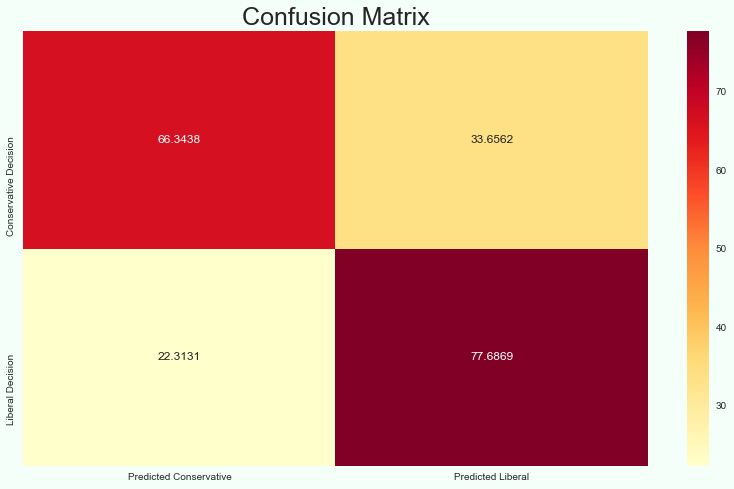


The following graph shows the ten most important factors in terms of model performance

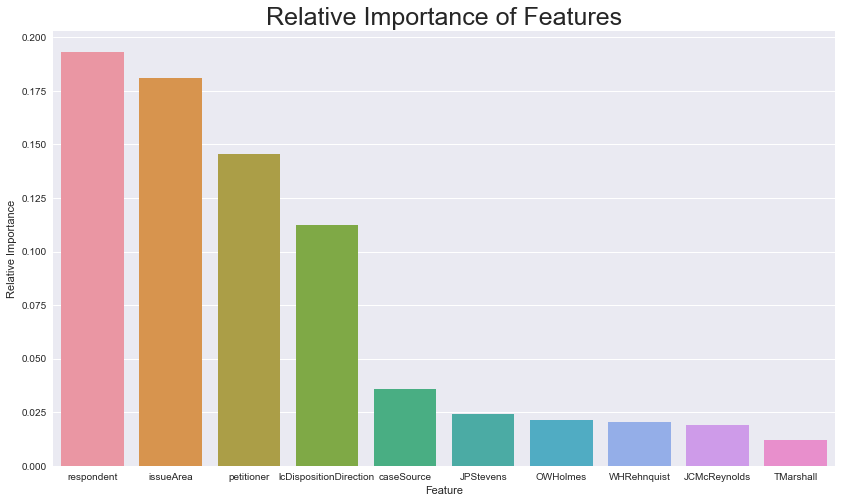

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_train = pd.read_csv('after1920_train.csv', encoding='ISO 8859-1', dtype='object', index_col=0)
## I created test tests for different time periods using the code in Notebook5

In [3]:
df_train.columns

Index(['adminAction', 'adminActionState', 'authorityDecision1',
       'authorityDecision2', 'caseDisposition', 'caseDispositionUnusual',
       'caseId', 'caseIssuesId', 'caseName', 'caseOrigin', 'caseOriginState',
       'caseSource', 'caseSourceState', 'certReason', 'chief', 'dateArgument',
       'dateDecision', 'dateRearg', 'decisionDirection',
       'decisionDirectionDissent', 'decisionType', 'declarationUncon',
       'docket', 'docketId', 'issue', 'issueArea', 'jurisdiction', 'lawMinor',
       'lawSupp', 'lawType', 'lcDisagreement', 'lcDisposition',
       'lcDispositionDirection', 'ledCite', 'lexisCite', 'majOpinAssigner',
       'majOpinWriter', 'majVotes', 'minVotes', 'naturalCourt', 'partyWinning',
       'petitioner', 'petitionerState', 'precedentAlteration', 'respondent',
       'respondentState', 'sctCite', 'splitVote', 'term', 'threeJudgeFdc',
       'usCite', 'voteId', 'voteUnclear'],
      dtype='object')

I removed a large number of columns because of the following reasons: 
information included in other columns for example docketId, caseIssuesId,and voteId are included in caseId 
information such as the name, id, docket, etc.of a case are also no likely predictive of the outcome
information such as the chief justice, term or naturalCourt are not likely relevant to individual votes
Information that is unavailable until after a decision and is not the target of the model should not be used
Columns with large amounts of missing data were also eliminated. This included the state level information

In [4]:
dropcols = ['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term',
            'chief', 'docket', 'caseName', 'dateArgument',
       'dateRearg', 'petitionerState',
       'respondentState', 'jurisdiction', 'adminAction', 'adminActionState',
       'threeJudgeFdc', 'caseOriginState',
       'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition',
        'declarationUncon', 'caseDisposition',
       'caseDispositionUnusual', 'partyWinning', 'precedentAlteration',
       'voteUnclear', 'issue',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'splitVote', 'majVotes', 'minVotes']

for col in dropcols:
    df_train.drop(col, axis=1, inplace=True)




In [5]:
df_train.shape

(11341, 8)

In [6]:
df_train = df_train[df_train.decisionDirection != '3']  ## removing non-political decisions
df_train.dropna(axis=0, inplace=True)


In [7]:
df_train.shape

(10529, 8)

In [8]:
target = 'decisionDirection'
y_train = df_train[target]
X_train = df_train[[col for col in df_train.columns if col != target]]

In [9]:
X_train.describe()

,caseOrigin,caseSource,issueArea,lcDispositionDirection,naturalCourt,petitioner,respondent
count,10529,10529,10529,10529,10529,10529,10529
unique,137,115,13,3,48,262,250
top,302,300,8,1,1103,27,27
freq,2295,2047,2992,5686,812,958,1393


Petitioner and Respondent are each categorical valiables with up to 310 categories.  I decided to combine categories based on the frequency of each category and based on the decriptions of each type at http://scdb.wustl.edu/documentation.php along with my subject matter knowledge of law and supreme court decisions. 

I created the speadsheet codelist.csv and a function to reduce the number of categories/
There were only 13 categories of issues, but some occur infrequently so I combined any missing values along with the less frequent cateories into one category: 'misc.' to again reduce the number of categories. 

In [10]:
parties = pd.read_csv("codelist.csv", index_col=None)
def party_categorizer(val):
    if val in parties.State.values:
        return '1'
    elif val in parties.Federal.values:
        return '2'
    elif val in parties.Criminal.values:
        return '3'
    elif val in parties.Liberal.values:
        return '4'
    elif val in parties.RTY.values:
        return '5'
    elif val in parties.Finance.values:
        return '6'
    elif val in parties.Business.values:
        return '7'
    elif val in parties.Political.values:
        return '8'
    elif val in parties.famend.values:
        return '9'
    else:
        return '10'
 

def issue_consolidate(num):
    if num == "None":
        return '13'
    if int(num) in [0, 3, 5, 6, 7, 11, 14]:
        return '13'
    else:
        return str(num)
    
       

Additonally there are 211 categories for case soure an case origin.  I combined these categories into 'state courts' and non-state courts with the lamda functions below. 

In [11]:
X_train.issueArea = X_train.issueArea.apply(lambda x: issue_consolidate(x))
X_train.petitioner = X_train.petitioner.apply(lambda x: party_categorizer(int(x)))                                  
X_train.respondent = X_train.respondent.apply(lambda x: party_categorizer(int(x)))
X_train.caseSource = X_train.caseSource.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')
X_train.caseOrigin = X_train.caseOrigin.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')

/Users/joshuapohl/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [12]:
X_train.shape

(10529, 7)

In [13]:
df_test = pd.read_csv('case_test_mod.csv', encoding='ISO 8859-1', dtype='object', index_col=0)
for col in dropcols:
    df_test.drop(col, axis=1, inplace=True) 
df_test = df_test[df_test.decisionDirection != '3']
df_test.dropna(axis=0, inplace=True)
y_test = df_test[target]
X_test = df_test[[col for col in X_train.columns]]
X_test.issueArea = X_test.issueArea.apply(lambda x: issue_consolidate(x))
X_test.petitioner = X_test.petitioner.apply(lambda x: party_categorizer(int(x)))                                  
X_test.respondent = X_test.respondent.apply(lambda x: party_categorizer(int(x)))
X_test.caseSource = X_test.caseSource.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')
X_test.caseOrigin = X_test.caseOrigin.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')

/Users/joshuapohl/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [14]:
X_test.shape

(1682, 7)

In [15]:
df_test.shape

(1682, 8)

I decided not to use the justice level voting data for my model.  However, I decided to use the naturalCourt columns that identifies the justices for each case -- and use naturalCourt to create dummy variables for each justice so that the identify of each justice is a feature for my model, although nothing more than the identity. 

In [16]:
judges_old = pd.read_csv('SCDB_Legacy_04_justiceCentered_Citation.csv', encoding='ISO 8859-1', dtype='object', index_col=0)
judges_new = pd.read_csv('justice_train_mod.csv', encoding='ISO 8859-1', dtype='object', index_col=0)

judges = pd.concat([judges_old, judges_new])
judges = judges[['naturalCourt', 'justiceName']]
courtdict = {}
for nc in judges['naturalCourt'].unique():
    courtdict[nc] = [x for x in (judges.loc[judges['naturalCourt'] == nc, :]['justiceName'].unique())]

def justices(key):
    return courtdict[key]


In [17]:
X_train['judgeList'] = X_train.naturalCourt.apply(justices)

In [18]:
X_test['judgeList'] = X_test.naturalCourt.apply(justices)

In [19]:
justice_list = judges.justiceName.unique()

In [20]:
for item in justice_list:
    X_train[item] = X_train.judgeList.apply(lambda x: '1' if item in x else '0')
    X_test[item] = X_test.judgeList.apply(lambda x: '1' if item in x else '0')

 Now that I have dummy variables for each justice, I will drop columns 'naturalCourt' and 'judgeList that I used to generate the dummy variables, but will not use directly.  I will also drop columns that contain redundant information, such as the presence and absence of the same justice. 

In [21]:
X_train.drop(['naturalCourt', 'judgeList'], axis=1, inplace=True)
X_test.drop(['naturalCourt', 'judgeList'], axis=1, inplace=True)


My list of justices (justice_list) includes justices that did not decide any cases during the period (1920-2016) in my training set, so I use the following code to remove the variables for justices that are not in the dataset.

In [22]:
goodcols = [x for x in X_train.describe().iloc[1, :][X_train.describe().iloc[1, :] != 1].index]
X_train = X_train[goodcols]
X_test = X_test[goodcols]

I use OneHotEndoder to create dummy variables for the cleaned categorical data.

In [23]:
ohc = OneHotEncoder(sparse=False)
ohc.fit(X_train)
X_trainX = ohc.transform(X_train)
X_testX = ohc.transform(X_test)

The data is ready for modelling, but I added the following code after the fact to make interpretation of the encoded data easier. 

In [24]:
fDICT = {}
for i in range(X_train.shape[1]):
    fDICT[ohc.feature_indices_[i]] = X_train.columns[i] + '0'

for k in range(ohc.active_features_[-1]+1):
    if k not in fDICT.keys():
        fDICT[k] = fDICT[k-1][:-1] + str(int(fDICT[k-1][-1]) + 1)

featinx = [x for x in fDICT.keys()]

for i in featinx:
    if i not in ohc.active_features_:
        fDICT.pop(i)

colist = []
for i in ohc.active_features_:
    colist.append(fDICT[i])

train_data = pd.DataFrame(X_trainX)
train_data.columns = colist
test_data = pd.DataFrame(X_testX)
test_data.columns = colist

cols = train_data.columns

keeps = []
for i in range(len(ohc.active_features_)-1):
    if cols[i][:8] == cols[i+1][:8]:
        keeps.append(cols[i])

train_data = train_data[keeps]
test_data = test_data[keeps]

Two of the models that I tried, but did not chose are KNN and Logistic Regression.  My work on these models in Notebook2. I also included my attempts at Gradient Boost and Keras in Notebook3 and Notebook4.  Random Forest provided greater consistent accuracy, so that is the model I chose.  I tuned the hyperparameters using the commented out code below.  I commented this portion out, because the code is slow.

In [25]:
#rfc = RandomForestClassifier(random_state=2017, n_jobs=-1)

In [26]:
# params = {
#     'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
#     'max_depth': [12, 13, 14, 15, 16],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [2, 3],
#     'min_samples_leaf': [1, 2, 3]
# }

In [27]:
# gs_rfc = GridSearchCV(rfc, param_grid=params, verbose=1, n_jobs=-1)

In [28]:
# gs_rfc.fit(train_data, y_train)

In [29]:
# gs_rfc.score(test_data, y_test)

In [30]:
# gs_rfc.best_params_

In [31]:
model = RandomForestClassifier(n_estimators=10, min_samples_leaf=2, max_depth=15, random_state=2017)

In [32]:
model.fit(train_data, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=2017,
            verbose=0, warm_start=False)

In [33]:
model.score(train_data, y_train)

0.7276094595878051

In [34]:
model.score(test_data, y_test)

0.643281807372176

Below I create a dataframe with the a column for features and a column for the importance of each feature.  I then sort this dataframe to find the most important features. 

In [35]:
imp_df = pd.DataFrame([train_data.columns, model.feature_importances_]).T

In [36]:
imp_df.columns = ['feature', 'importance']

In [37]:
imp_df['feature'] = imp_df.feature.apply(lambda x: x[:-2] if x[-2] == '1' else x[:-1] )

In [38]:
combo_imp = imp_df.groupby('feature').sum()

In [39]:
combo_imp.features = [x for x in combo_imp.index]

In [40]:
top_features = combo_imp.sort_values('importance', ascending=False).head(10)

In [41]:
top_features.reset_index(inplace=True)

In [42]:
top_features

,feature,importance
0,respondent,0.194822
1,issueArea,0.176424
2,petitioner,0.149601
3,lcDispositionDirection,0.109185
4,caseSource,0.041567
5,WHRehnquist,0.021022
6,JCMcReynolds,0.021000
7,WODouglas,0.019102
8,FFrankfurter,0.014993
9,HABlackmun,0.013559


[<matplotlib.text.Text at 0x1116601d0>, <matplotlib.text.Text at 0x115542e48>]

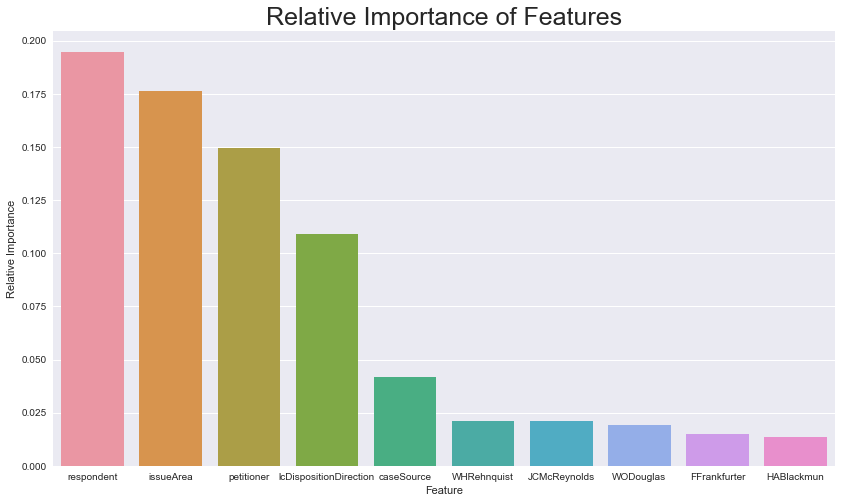

In [43]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
ax.set_title("Relative Importance of Features", fontdict={'fontsize': 25})
ax = sns.barplot(x="feature", y="importance", data=top_features)
ax.set(xlabel='Feature', ylabel='Relative Importance')


Below is code for a Confusion Matrix Visualization

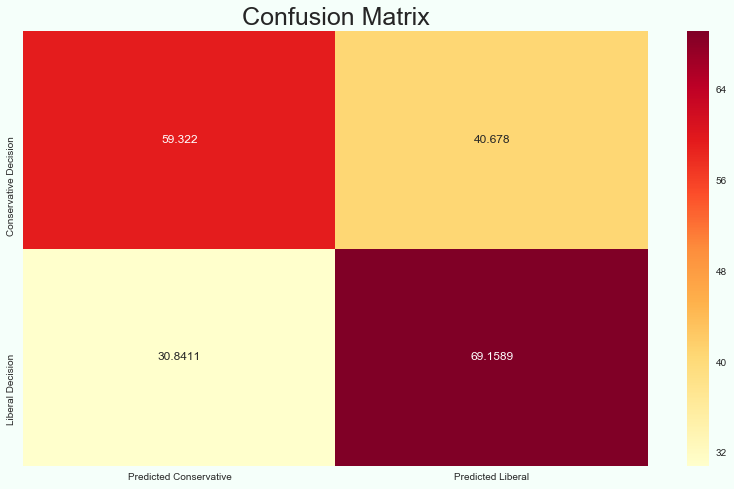

In [44]:
yhat = model.predict(test_data)
conmat = np.array(confusion_matrix(y_test, yhat))
confusion = pd.DataFrame(conmat, index=['Conservative Decision', 'Liberal Decision'],
                         columns=['Predicted Conservative','Predicted Liberal']).apply(lambda x: 100* x/x.sum(),axis=1)

fig, ax = plt.subplots()
ax.set_title("Confusion Matrix", fontdict={'fontsize': 25})
fig.set_size_inches(14, 8)
fig.patch.set_facecolor('mintcream')
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlOrRd')

The below classification report provides additional metrics for my model

In [45]:
target_names = ['Conservative Direction', 'Liberal Direction']
print(classification_report(y_test, yhat, target_names=target_names))

                        precision    recall  f1-score   support

Conservative Direction       0.65      0.59      0.62       826
     Liberal Direction       0.64      0.69      0.66       856

           avg / total       0.64      0.64      0.64      1682



### Next Steps

1. Refine Model to include Time-Series information as well as justice level data.  Some research has been performed in this area that measures justices numerically, and I will strongly consider that.
2. Review Feature Selection, since that was the biggest challenge for this model.  
3. Review coding of features -- I may try other types of coding perhaps based on unsupervised learning techniques.
4. Apply the model to 2017 and later cases to see how it performs 
